In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
import numpy as np

print('PyTorch version:', torch.__version__)
print('PyTorch working with CUDA:', torch.cuda.is_available())

PyTorch version: 2.9.0+cu130
PyTorch working with CUDA: True


In [4]:
# Ordered list of data labels as per Fashion MNIST Documentation
data_labels = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
               "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Data pre-processing transformations
transforms = Compose([
    ToTensor(), 
    Normalize(mean=0.5, std=0.5)
])

# Initialises data
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms
)

# Batch Size Hyperparameter (default = 64)
batch_size = 64

# Load the data with automatic shuffling for training
train_loader = DataLoader(training_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)


train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# Tests
train_expected_size = torch.Size([batch_size,1,28,28])
assert train_images.shape == train_expected_size

expected_label_size = torch.Size([batch_size])
assert train_labels.shape == expected_label_size

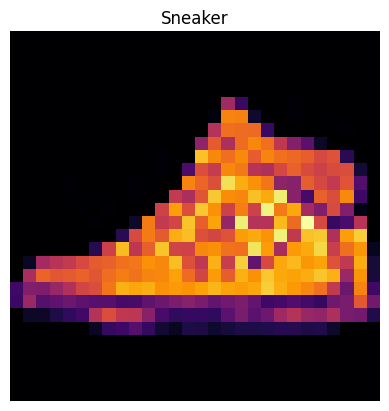

In [5]:
# Plot of random sample with label
img = train_images[0].squeeze()
label = data_labels[train_labels[0]]

fig = plt.imshow(img)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.set_cmap('inferno')
plt.title(label)
plt.show()

In [6]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, hidden1,hidden2,hidden3,in_features=28*28, out_features=10):
        '''
        3-Layer MLP with specifiable hidden layer size
        Args:
            hidden1 (int): specify the number of neurons in layer 1
            hidden2 (int): specify the number of neurons in layer 2
            hidden3 (int): specify the number of neurons in layer 3
            in_features (int/optional): specify the number of inputs (size of flattened image = length * width)
            out_features (int/optional): specify the number of outputs (number of classes)
        '''
        super().__init__()
        self.flatten = nn.Flatten()
        self.lin_relu_stack = nn.Sequential(
            nn.Linear(in_features,hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2,hidden3),
            nn.ReLU(),
            nn.Linear(hidden3, out_features),
      )

    def forward(self, x):
        '''
        Perform a forward pass of the network.
        Note: This flattens the image for us so we need not reshape input data.
        Args:
            x (tensor): datapoint from our data
        '''
        x = self.flatten(x)
        output = self.lin_relu_stack(x)
        output = F.softmax(output, dim=1)
        return output

In [7]:
# Initialise model and check structure
ann_model = MultilayerPerceptron(1024,512,256)
print(ann_model)

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [8]:
def train(dataloader, model, loss_fn, optim):
    '''
    Perform a simple training pass for one epoch
    Args:
        dataloader (Dataloader(data)): Dataloader using torchvision
        model (ANN/CNN): Chosen model
        loss_fn: Loss function used
        optim: optimiser used for gradient parameter adjustment
    '''
    model.train()
    num_batch = len(dataloader)
    train_loss = 0
    for X,label in dataloader:
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batch
    print(f'Training loss = {train_loss:>5f}')
    return train_loss

def test(dataloader, model):
    '''
    Perform a test pass.
    Args:
        dataloader (DataLoader(data)): Dataloader of a dataset using torchvision
        model (ANN/CNN): Chosen model
    '''
    model.eval()
    num_batch = len(dataloader)
    test_loss = 0
    for X,label in dataloader:
        pred = model(X)
        loss = loss_fn(pred, label)
        test_loss += loss.item()
    test_loss /= num_batch
    print(f'Test loss = {test_loss:>5f}')
    return test_loss

In [9]:
# initial hyperparameters
learn_rate = 1e-3
epochs = 5

# initialise loss function and optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ann_model.parameters(), lr=learn_rate, momentum=0.9)

In [10]:
# training/test loop
loss_hist = []
for e in range(epochs):
    print(f'Epoch {e+1}/{epochs}')
    train_loss = train(train_loader, ann_model, loss_fn, optimizer)
    test_loss = test(test_loader, ann_model)
    loss_hist.append([train_loss,test_loss]) 

Epoch 1/5
Training loss = 2.294888
Test loss = 2.281665
Epoch 2/5
Training loss = 2.192503
Test loss = 2.063239
Epoch 3/5
Training loss = 1.940457
Test loss = 1.841827
Epoch 4/5
Training loss = 1.800798
Test loss = 1.768382
Epoch 5/5
Training loss = 1.745448
Test loss = 1.729611


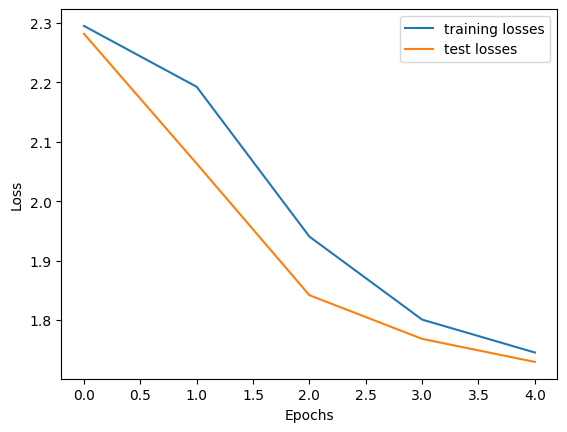

In [11]:
plt.plot(loss_hist, label=["training losses","test losses"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()